# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms
import numpy as np
import os
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
checkpoint_loc = '/content/gdrive/MyDrive/11785/project/'

Mounted at /content/gdrive


# Visualization Module

In [48]:
class VisualizeNetwork(object):
  def plot_filters_single_channel(self,t):
    nplots = t.shape[0]
    print(nplots)
    ncols = 12
    nrows = 1 + nplots//ncols
    npimg = np.zeros(t.shape[2], np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            npimg = np.add(npimg,np.array(t[i, j].numpy(), np.float32))     
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        ax1.imshow(npimg)
        ax1.set_title(str(i) + ',' + str(j))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()
    plt.close()
    
  def display_kernel(self,model,save=False, filename = ''):
    for (index, module) in model.features._modules.items():
      if isinstance(module, nn.Conv2d):
        print(module)
        weight_tensor = module.weight.data
        self.plot_filters_single_channel(weight_tensor)

  def display_scatter_plot(self,old_model,new_model,save=False, filename = ''):
     for (index, module) in old_model.features._modules.items():
      if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
        print(index)
        print('-'*10,' name:', module)
        weight = module.weight.data.cpu().numpy()
        flatten_weights = weight.flatten()
        (weights, count) = np.unique(flatten_weights, return_counts=True)
        
        weight_p = new_model.features[int(index)].weight.data.cpu().numpy()
        flatten_weights_p = weight_p.flatten()
        (weights_p, count_p) = np.unique(flatten_weights_p, return_counts=True)


        plt.scatter(weights, count, alpha=0.5)
        plt.scatter(weights_p, count_p)
        plt.xlabel('values of weights')
        plt.ylabel('frequency of repetition')
        print('layer_names [',module.__class__.__name__,'] -> unique weights count old:',len(weights_p),', new:',len(weights))
        plt.show()
    
  def activation_hook(self,inst, inp, out):
    data = out.cpu().data.numpy()
    plt.title((inst))
    if data.ndim == 2:
      plt.matshow(data, cmap='hot', interpolation='nearest')
    else:
      plt.matshow(data[0][0], cmap='hot', interpolation='nearest')

  def display_activations(self,model,x):
    x = x.cpu()
    plt.imshow(x[0][0])
    x = x.cuda()
    model = model.cuda()
    hook_list = []
    for (name, module) in model.features._modules.items():
      if isinstance(module,nn.ReLU) :
        h = module.register_forward_hook(self.activation_hook)
        hook_list.append(h)
    for (name, module) in model.classifier._modules.items():
      if isinstance(module,nn.ReLU) :
        hook_list.append(h)
        h = module.register_forward_hook(self.activation_hook)
    y = model(x)
    for hh in hook_list:
      hh.remove()
    hook_list = []

# testing pre-requisites

In [5]:
VGG_CONFIGS = {
    # M for MaxPool, Number for channels
    'D': [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M',
        512, 512, 512, 'M'
    ],
}


class VGG_SNIP(nn.Module):
    """
    This is a base class to generate three VGG variants used in SNIP paper:
        1. VGG-C (16 layers)
        2. VGG-D (16 layers)
        3. VGG-like

    Some of the differences:
        * Reduced size of FC layers to 512
        * Adjusted flattening to match CIFAR-10 shapes
        * Replaced dropout layers with BatchNorm
    """

    def __init__(self, config, num_classes=10):
        super().__init__()

        self.features = self.make_layers(VGG_CONFIGS[config], batch_norm=True)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # 512 * 7 * 7 in the original VGG
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, num_classes),
        )

    @staticmethod
    def make_layers(config, batch_norm=False):  # TODO: BN yes or no?
        layers = []
        in_channels = 3
        for v in config:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [
                        conv2d,
                        nn.BatchNorm2d(v),
                        nn.ReLU(inplace=True)
                    ]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
post_process_net = torch.load('/content/gdrive/MyDrive/11785/project/after_quantization_8.ptmodel')

Input loaders and dataset for activation visualization

In [31]:
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INIT_LR = 0.1
WEIGHT_DECAY_RATE = 0.0005
EPOCHS = 70
lr_decay_interval = 10
batch_size = 128

def get_cifar10_dataloaders(train_batch_size, test_batch_size):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = CIFAR10('_dataset', True, train_transform, download=True)
    test_dataset = CIFAR10('_dataset', False, test_transform, download=False)

    train_loader = DataLoader(
        train_dataset,
        train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    test_loader = DataLoader(
        test_dataset,
        test_batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

    return train_loader, test_loader
def cifar10_experiment():
    
    BATCH_SIZE = 128
    LR_DECAY_INTERVAL = 20
    
    net = VGG_SNIP('D').to(device)
    # net = 
    optimiser = optim.SGD(
        net.parameters(),
        lr=INIT_LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY_RATE)
    lr_scheduler = optim.lr_scheduler.StepLR(
        optimiser, LR_DECAY_INTERVAL, gamma=0.1)
    
    train_loader, val_loader = get_cifar10_dataloaders(BATCH_SIZE,
                                                       BATCH_SIZE)  # TODO

    return net, optimiser, lr_scheduler, train_loader, val_loader
initial_net, optimiser, lr_scheduler, train_loader, val_loader = cifar10_experiment()


Extracting _dataset/cifar-10-python.tar.gz to _dataset


# Test cases

In [49]:
vn = VisualizeNetwork()
post_process_net.cpu()

VGG_SNIP(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

Visualizing kernels

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
64


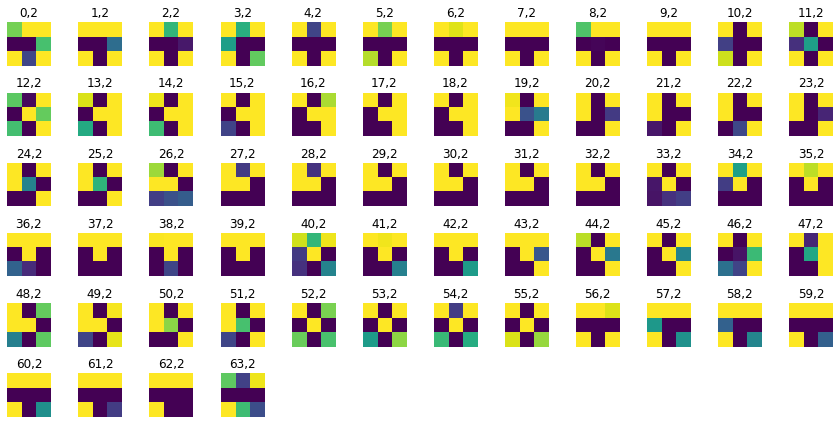

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
64


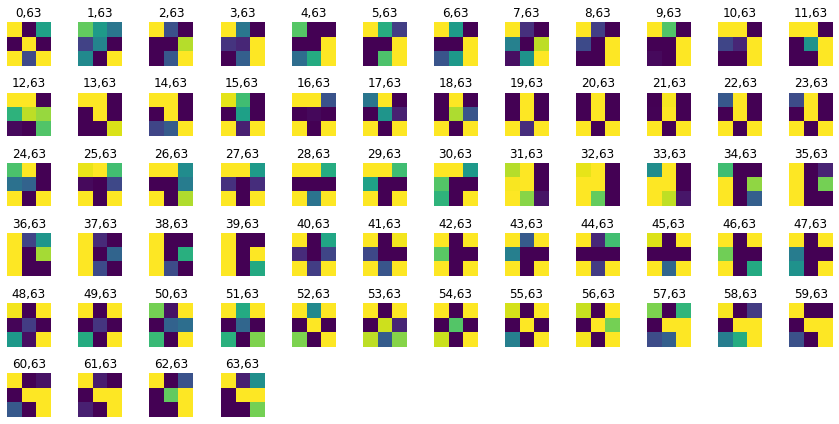

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
128


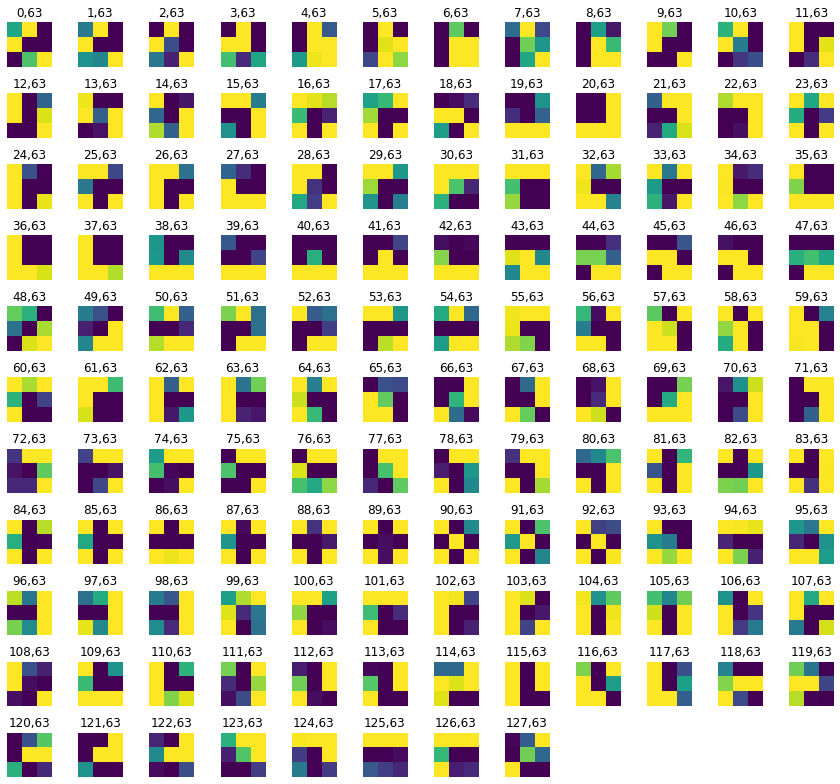

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
128


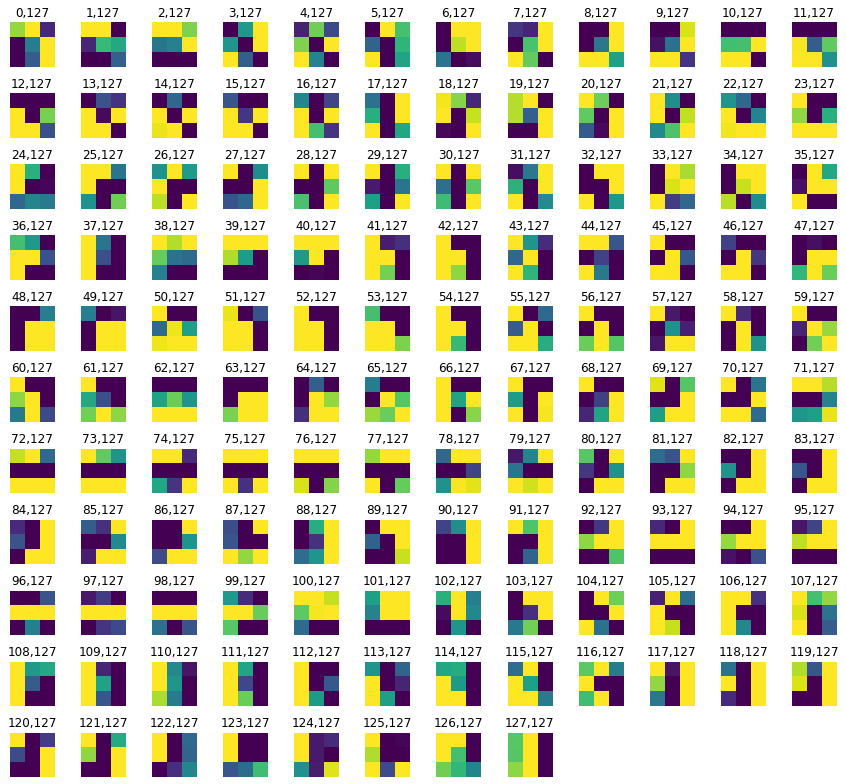

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
256


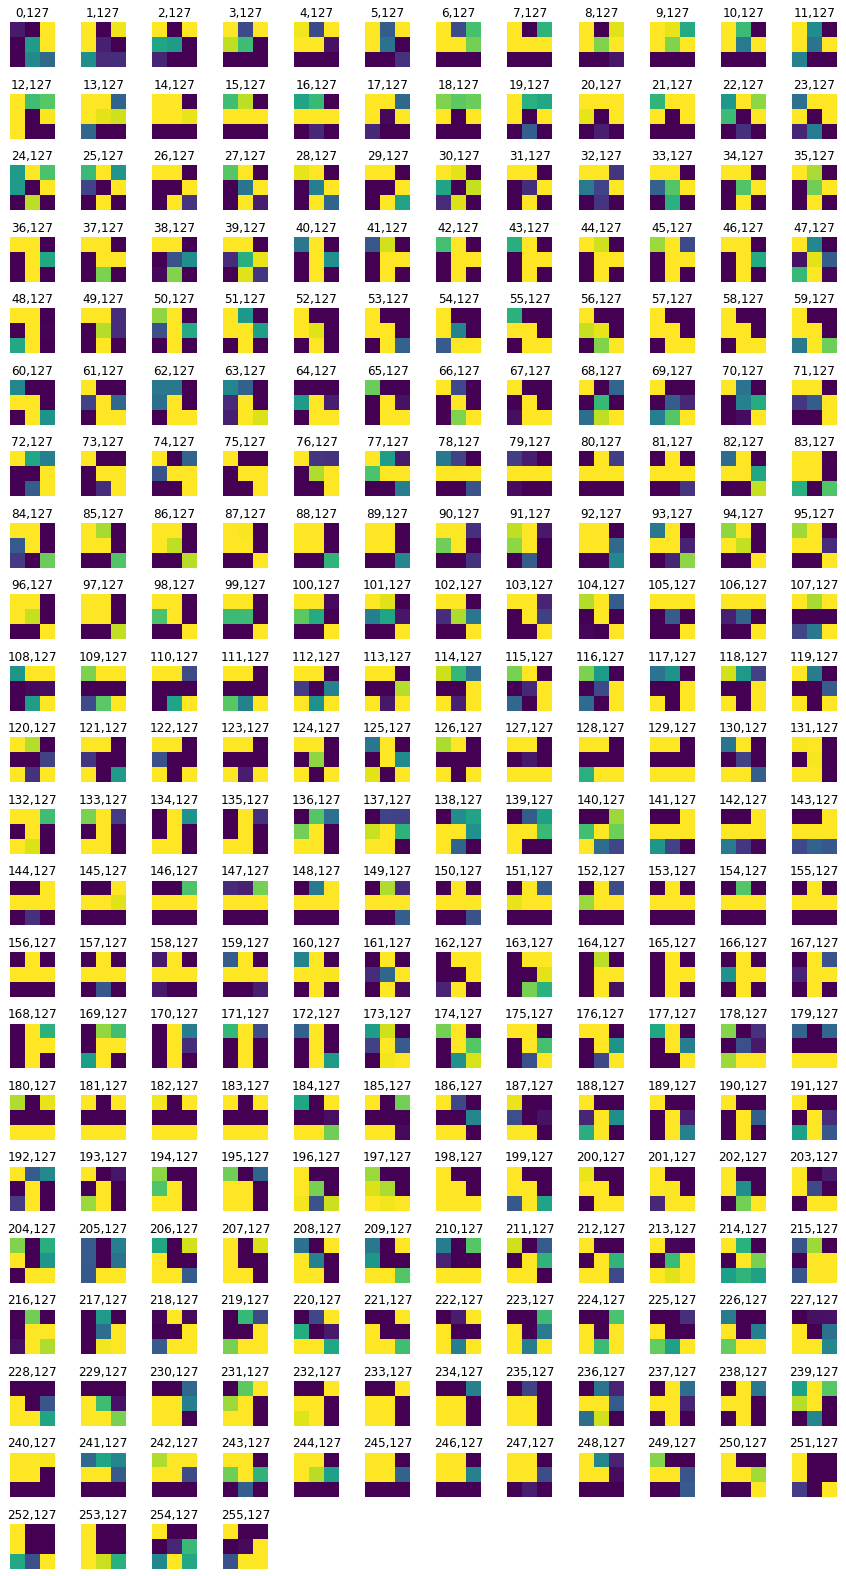

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
256


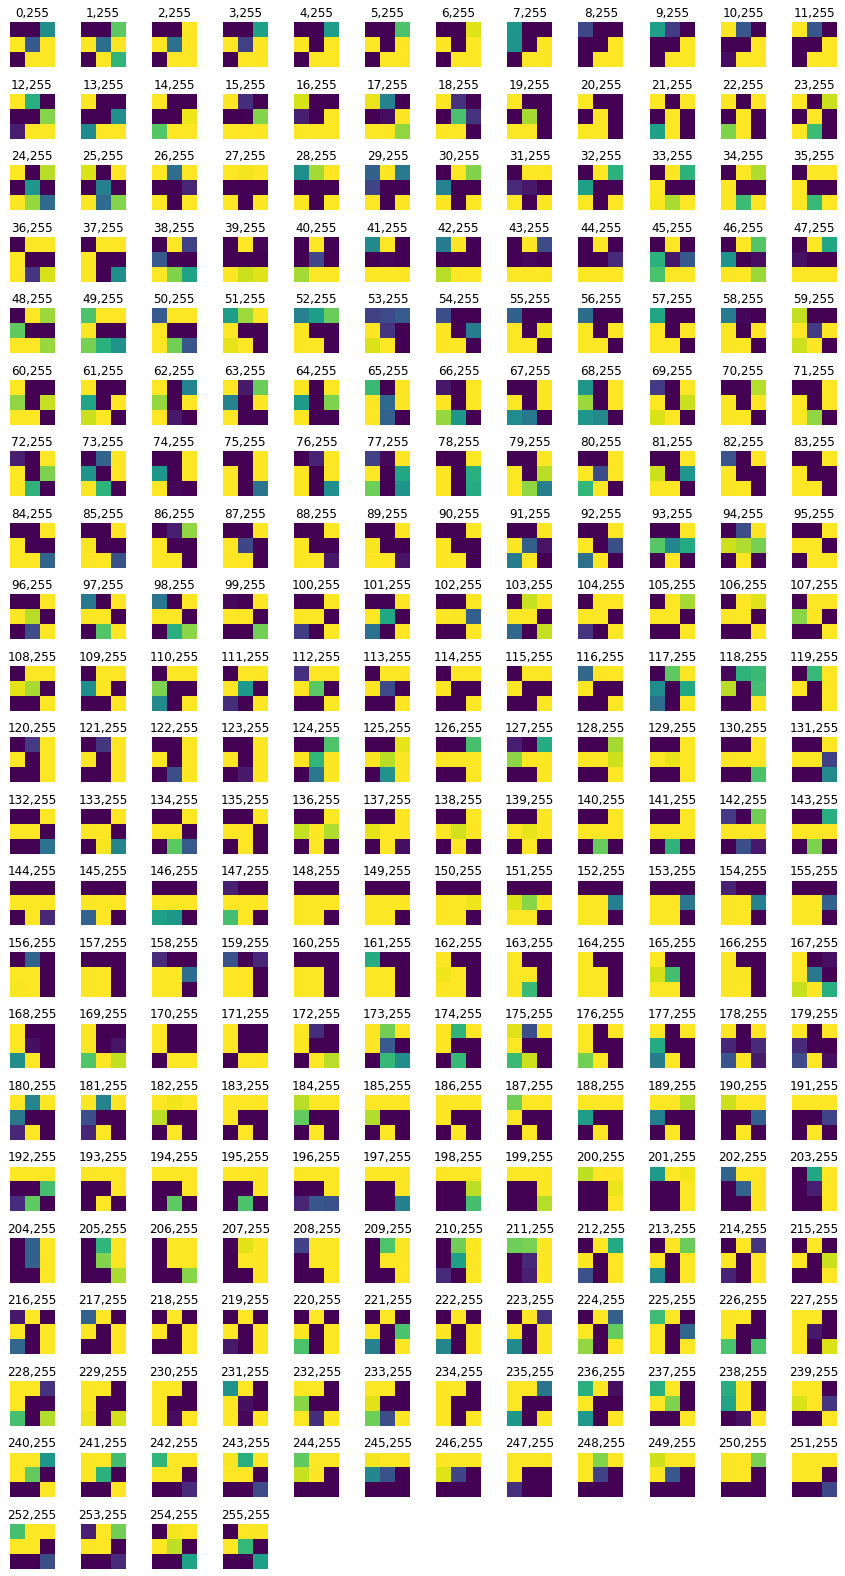

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
256


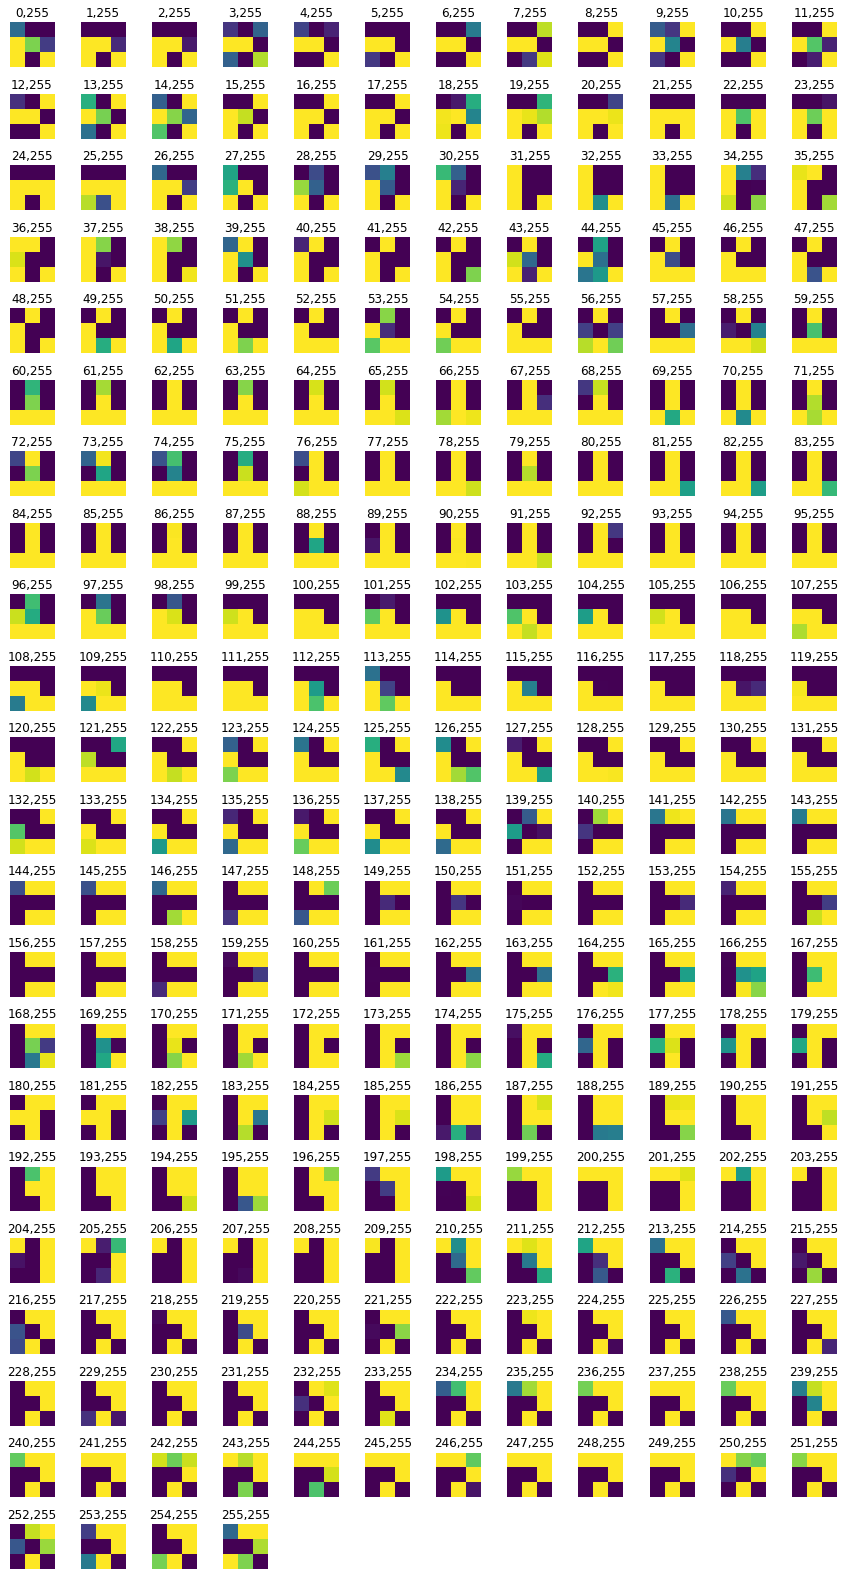

Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


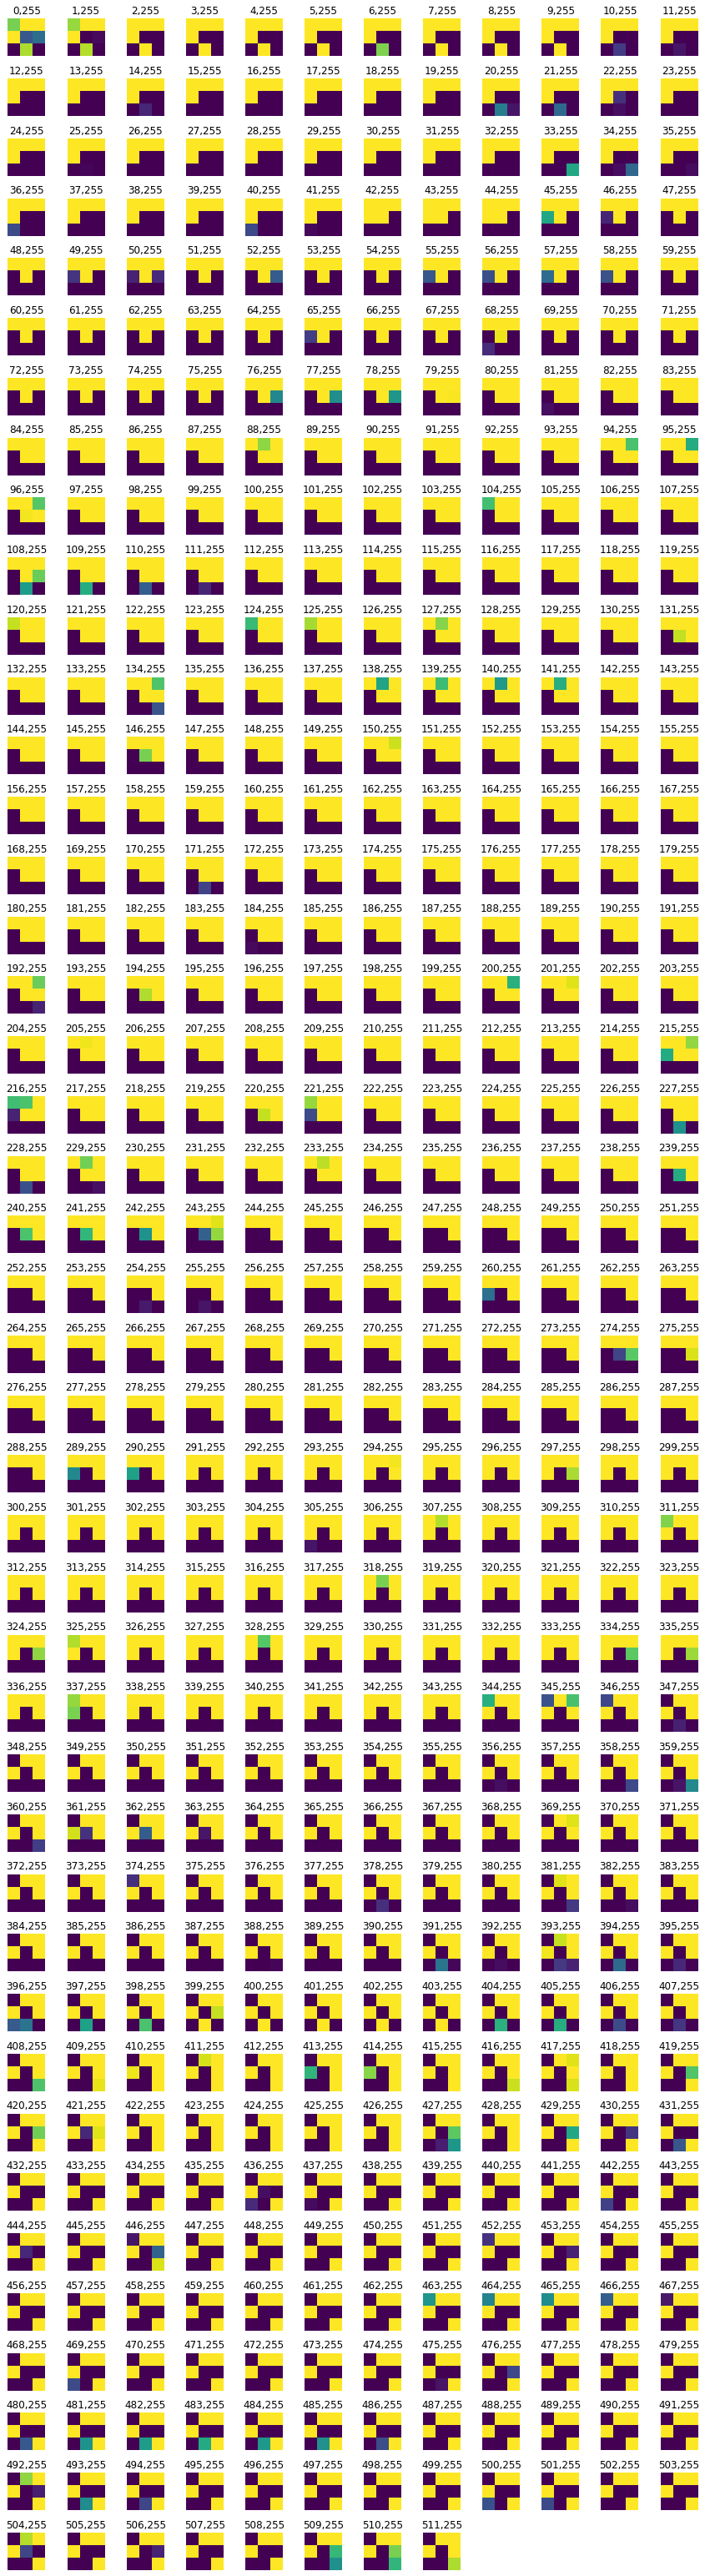

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


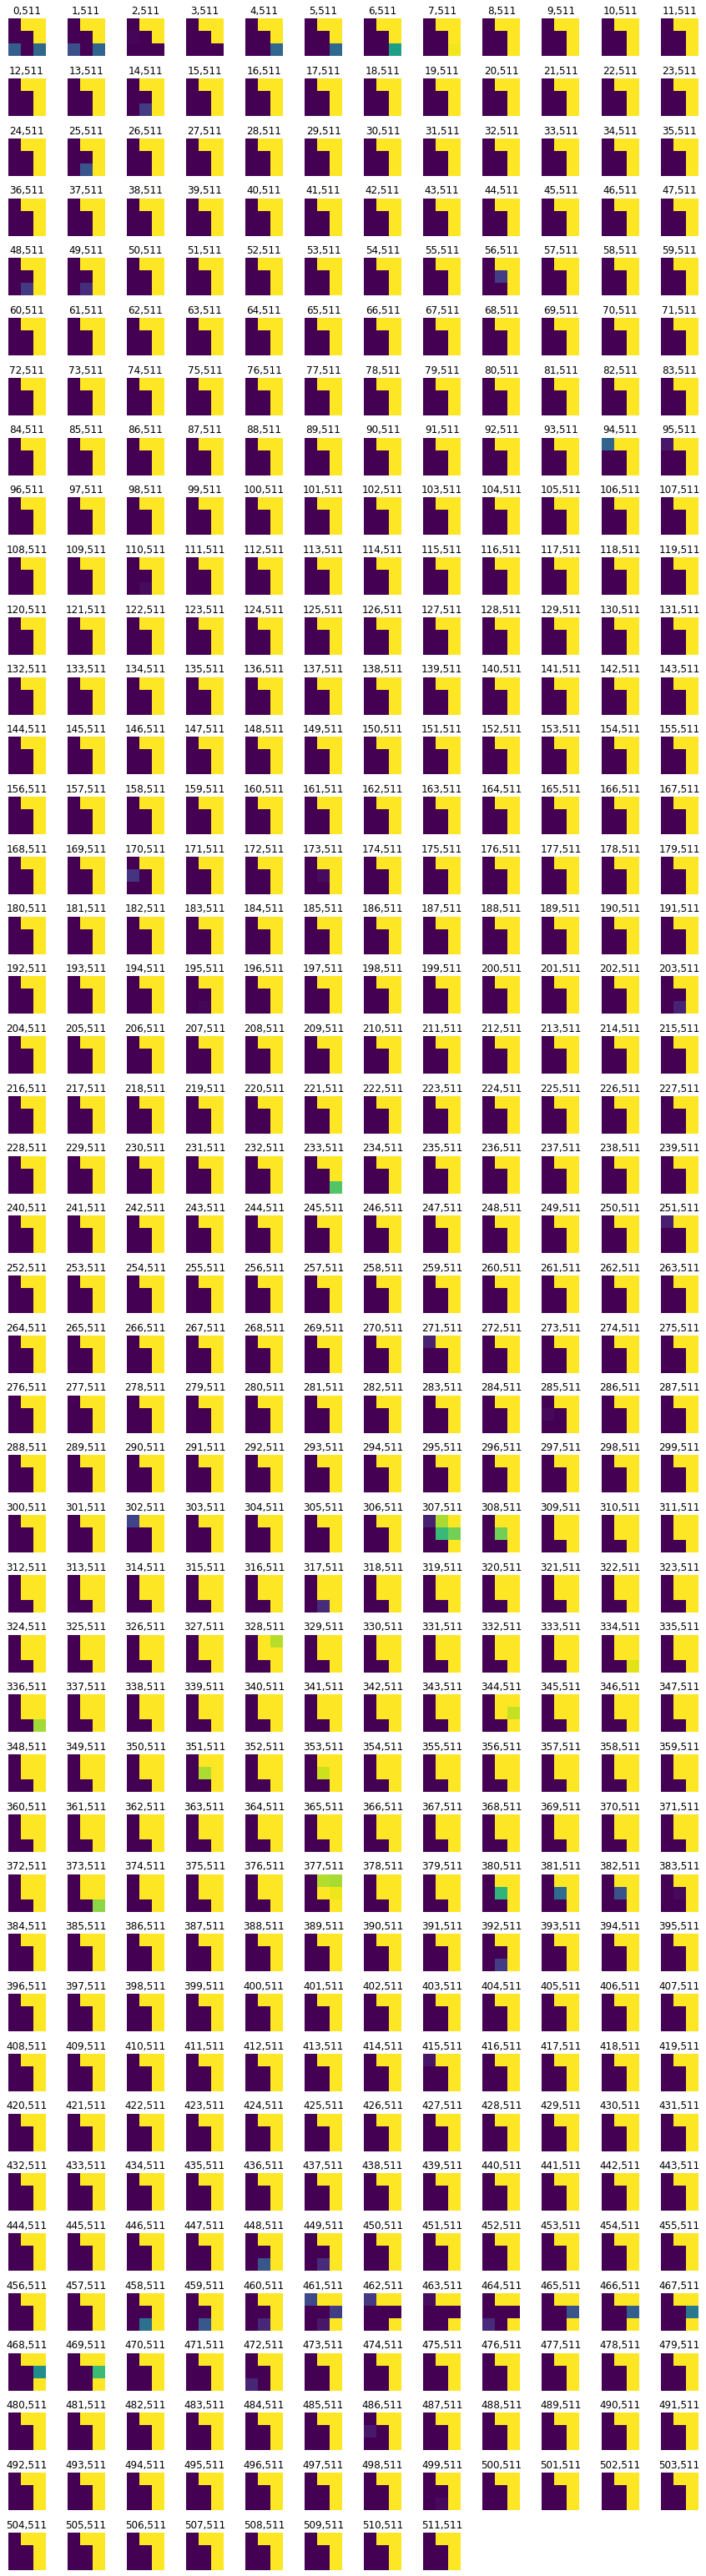

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


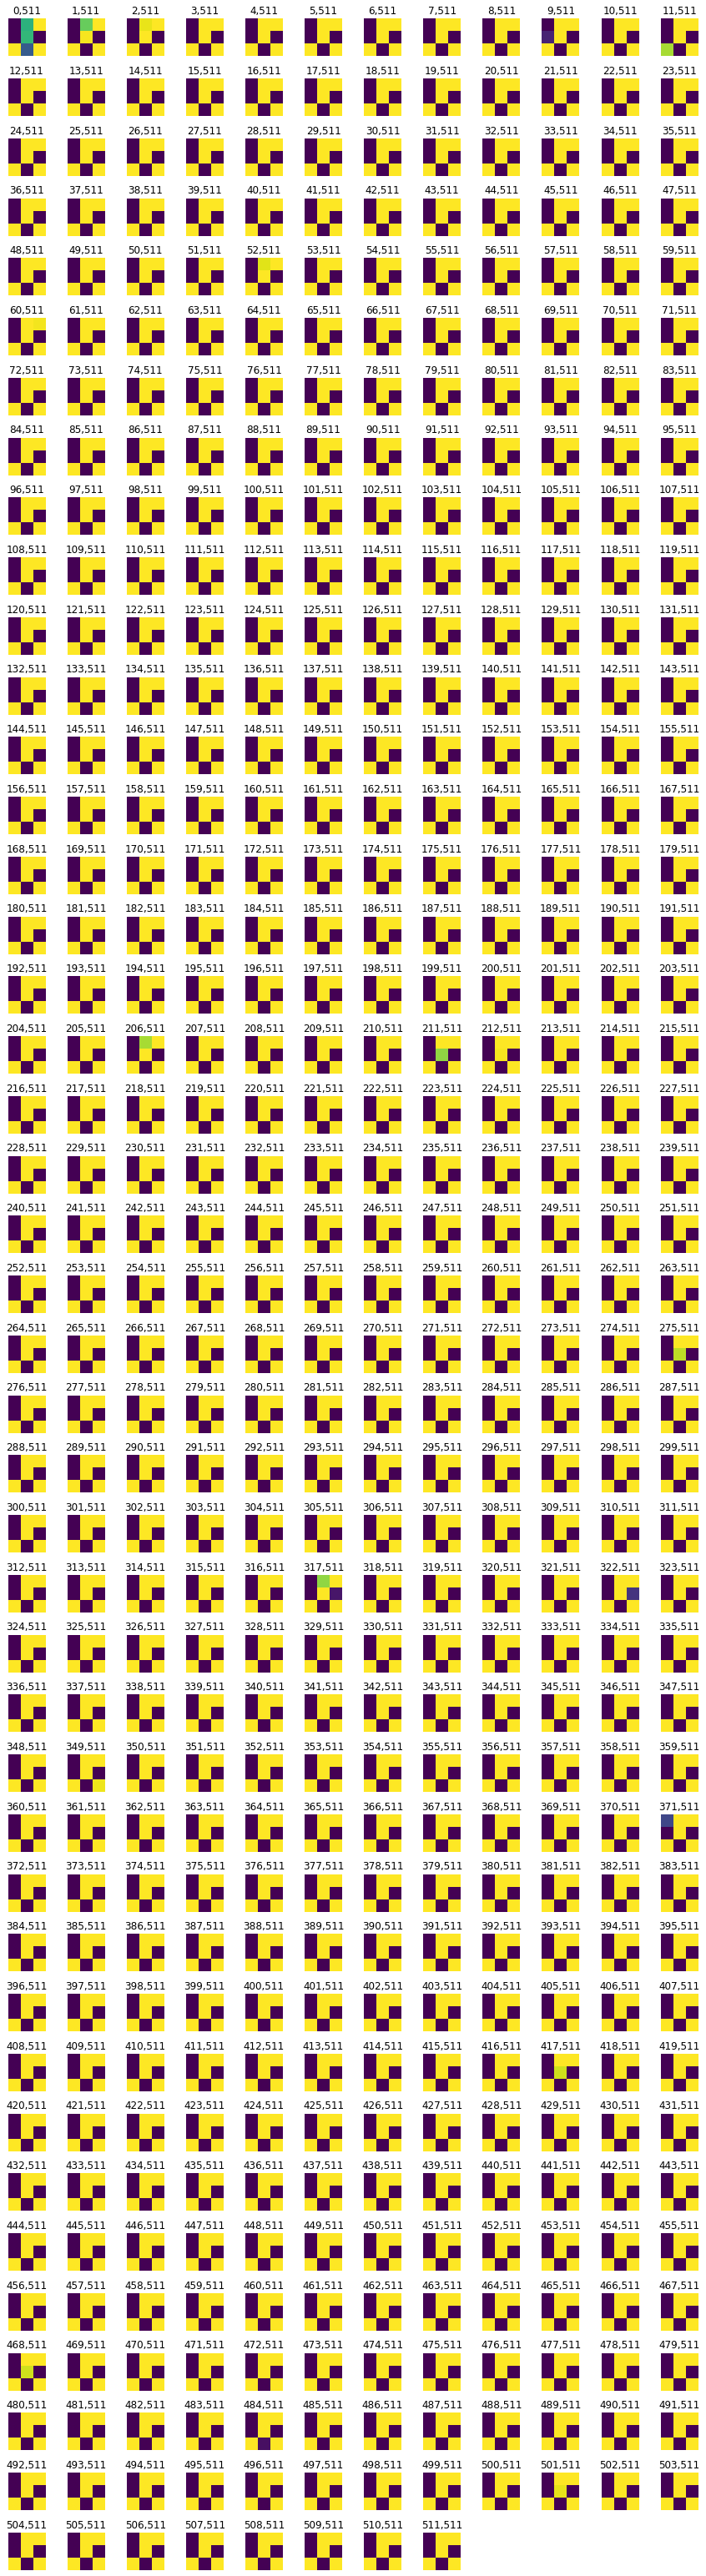

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


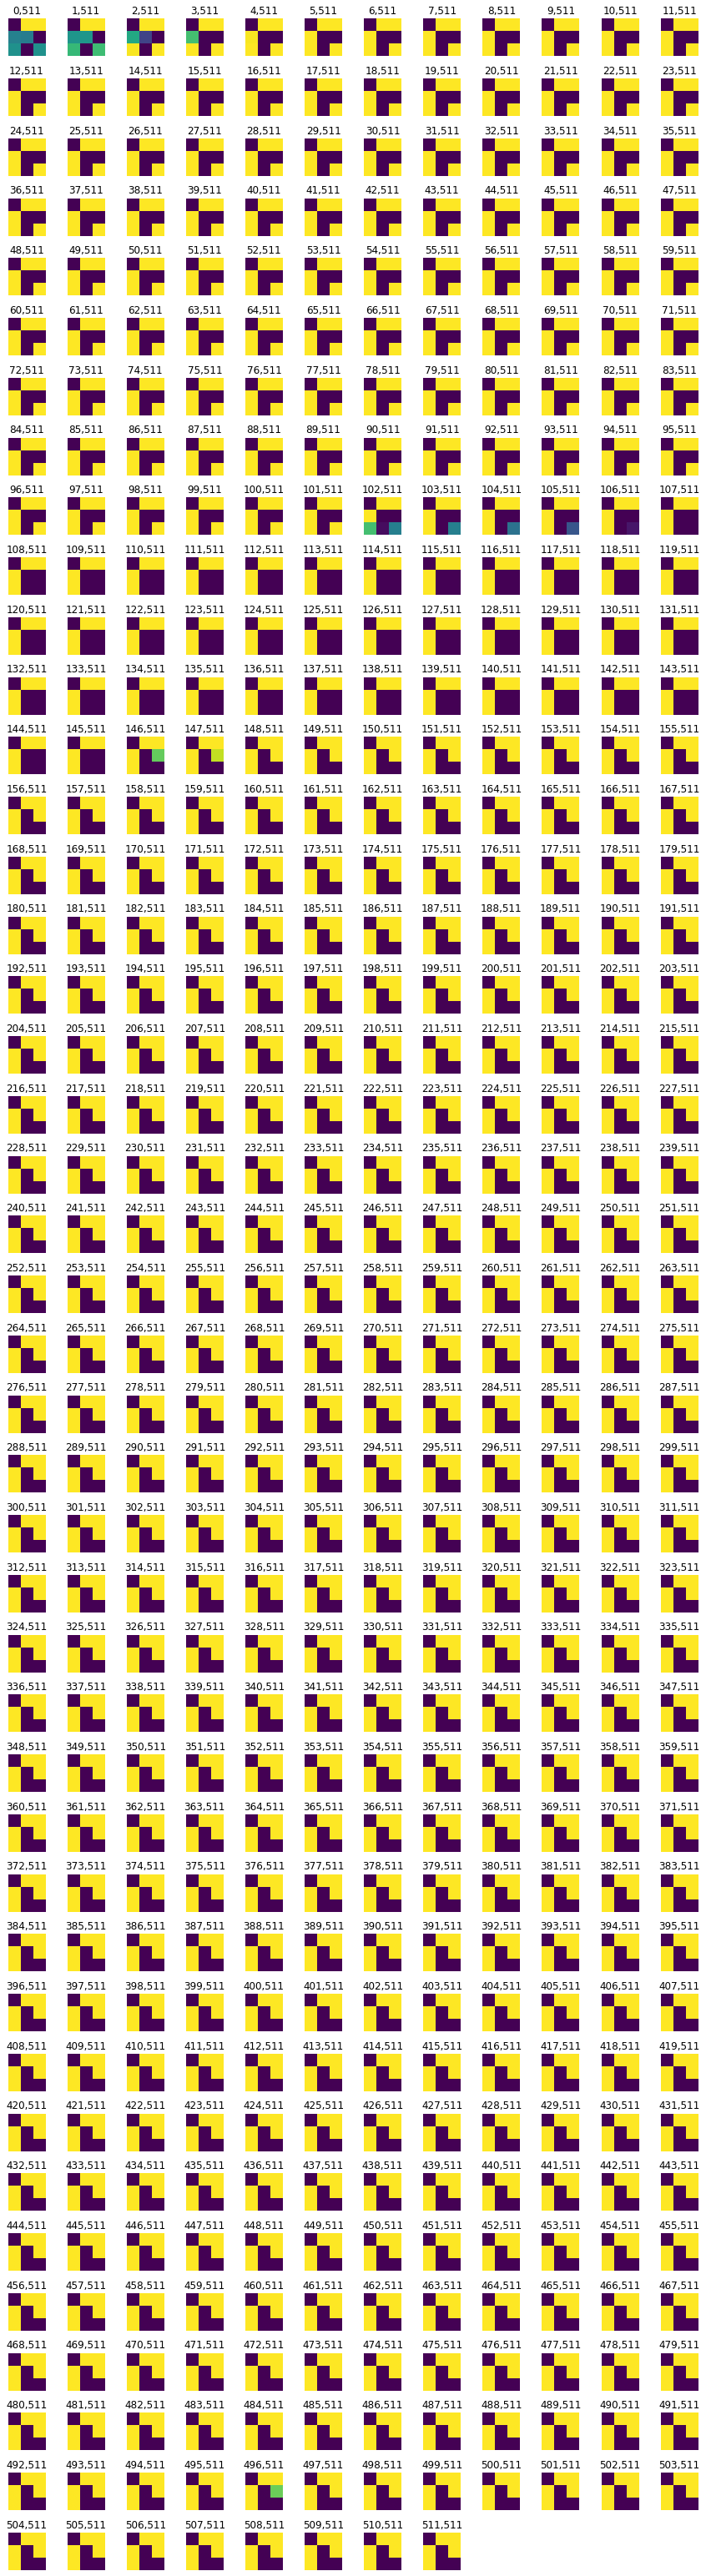

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


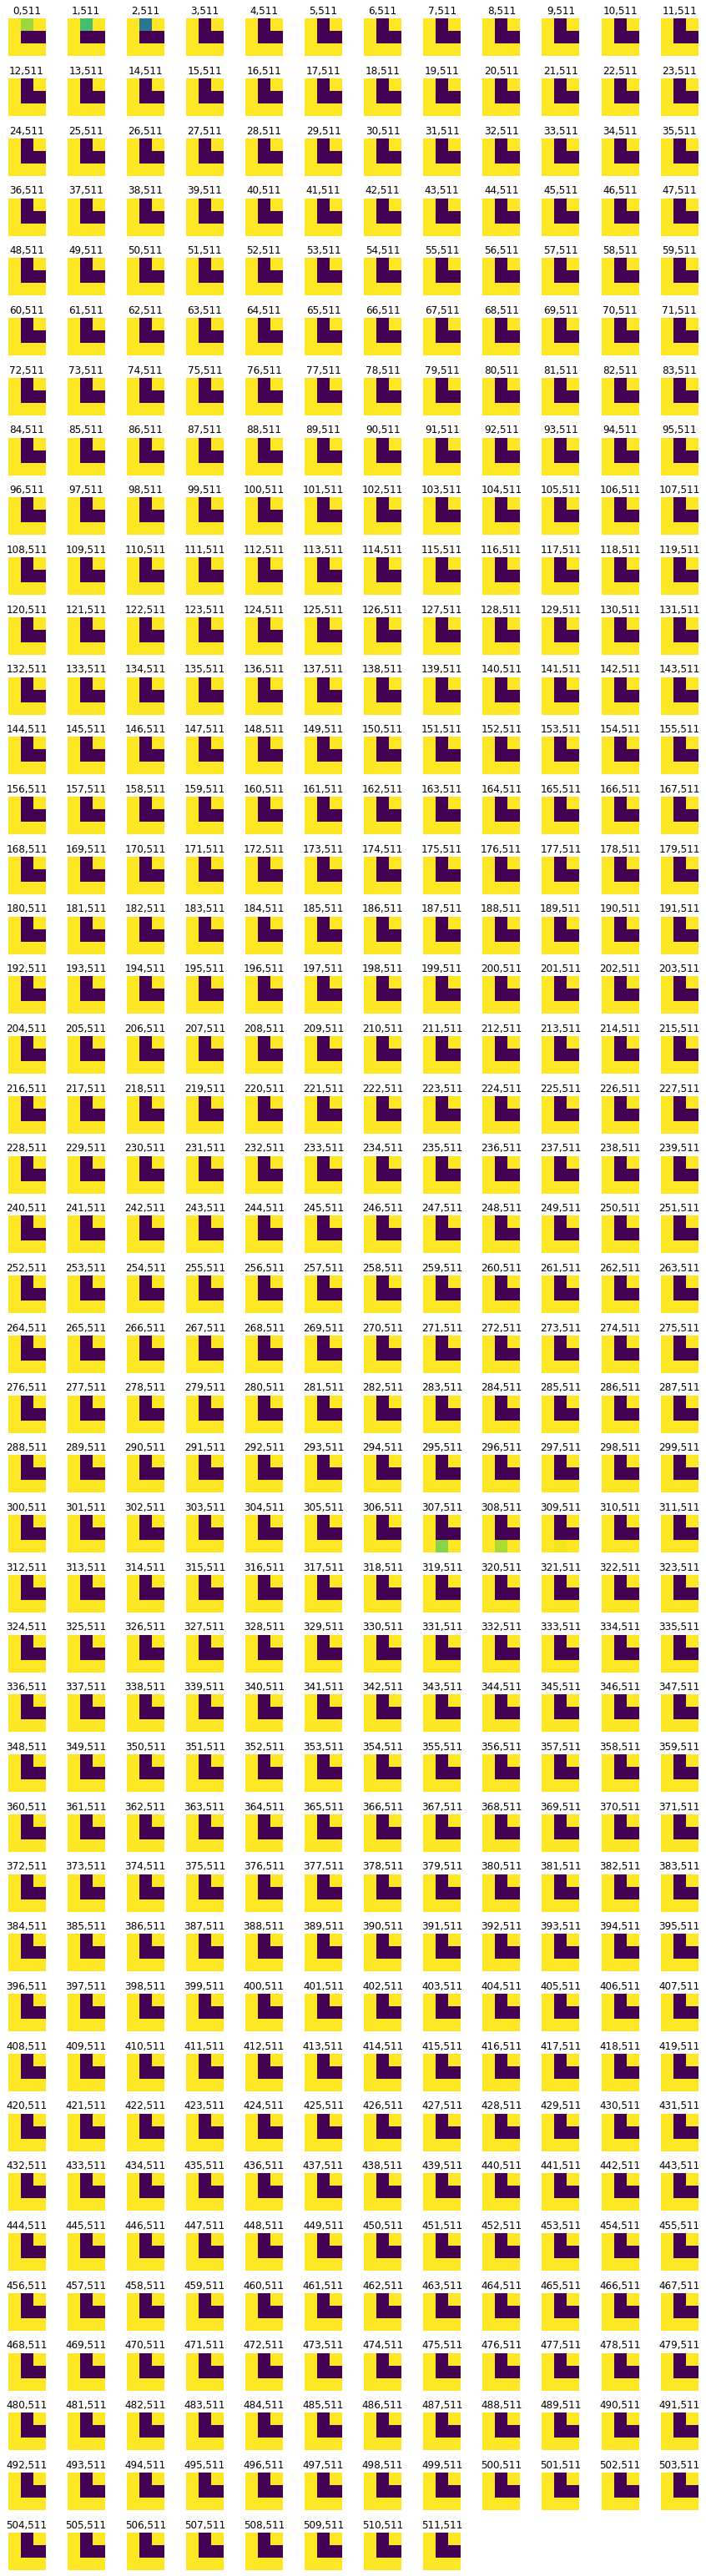

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
512


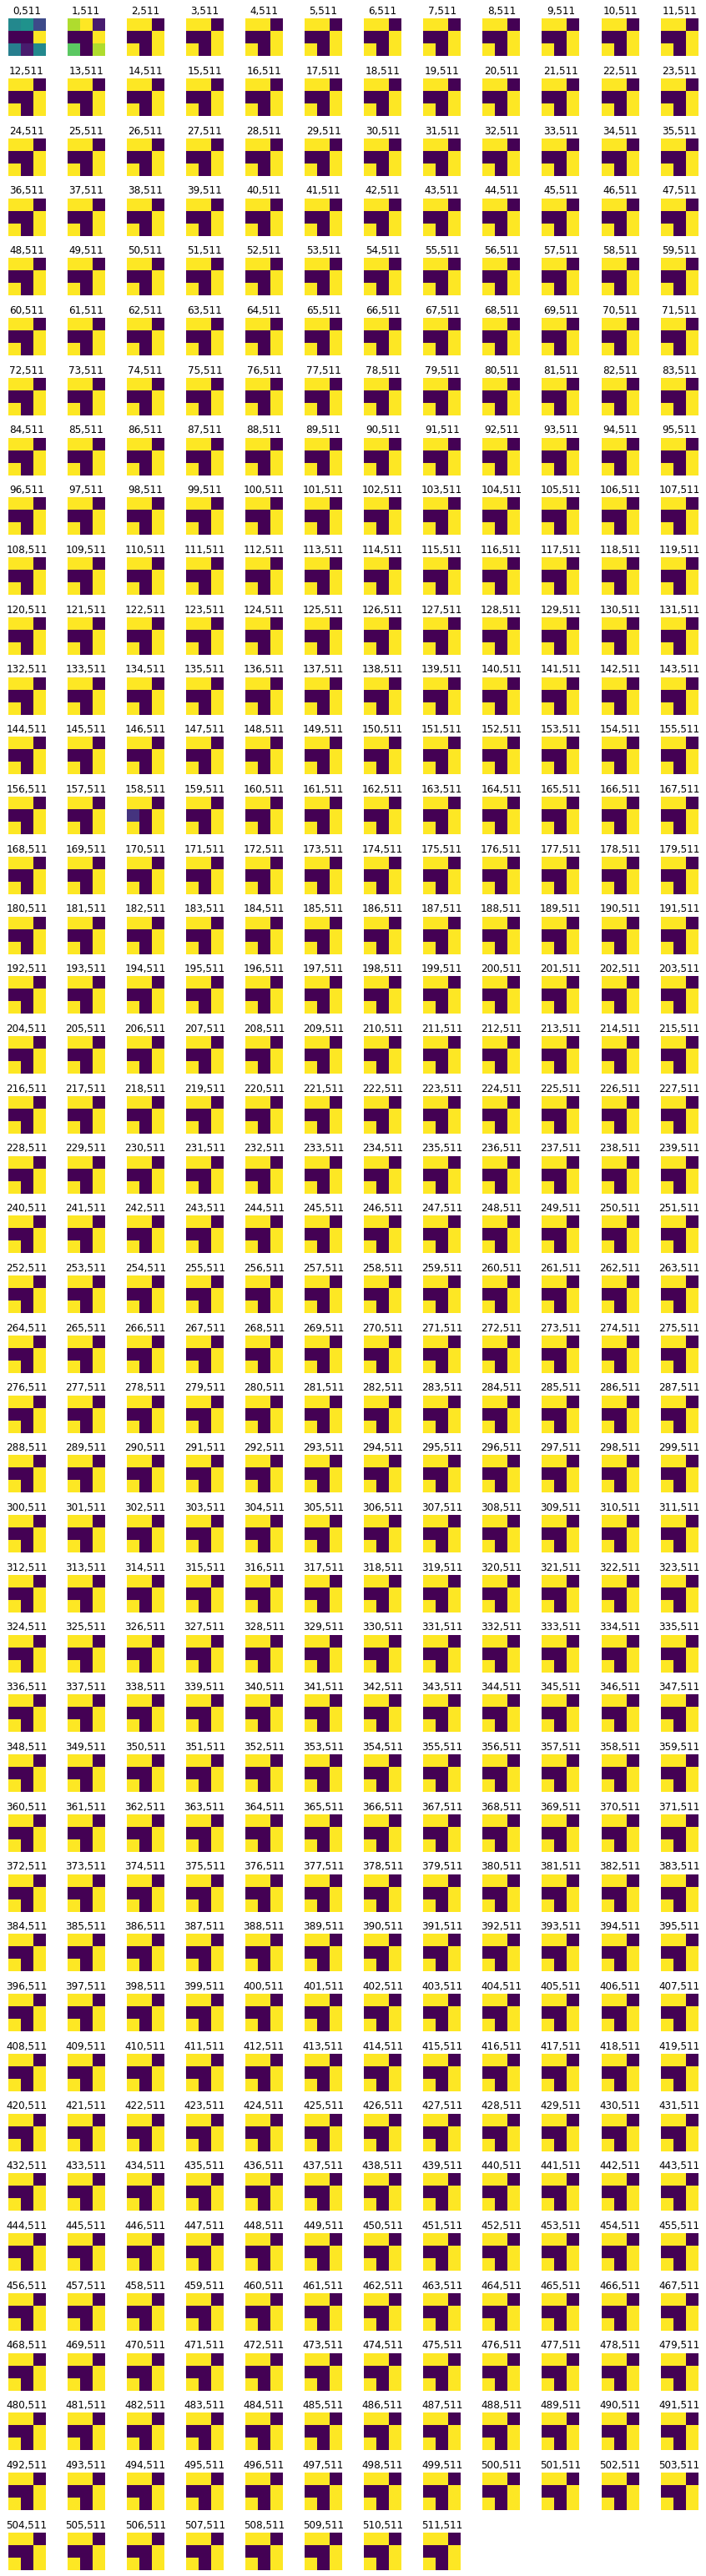

In [9]:
vn.display_kernel(post_process_net)

Scatter plotting weights

0
----------  name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 1728


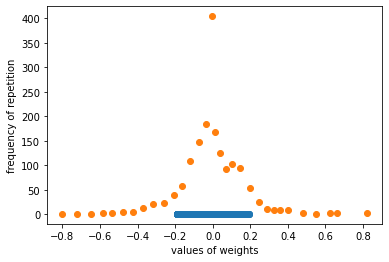

1
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


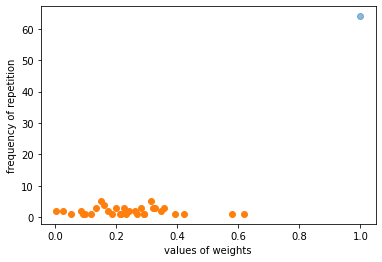

3
----------  name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 36831


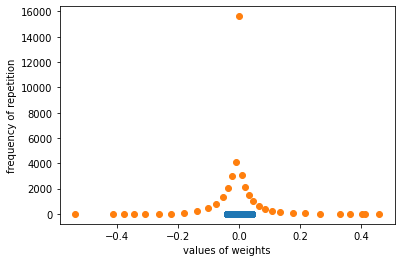

4
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


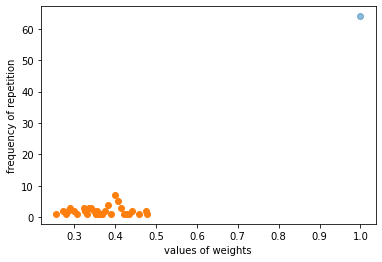

7
----------  name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 73576


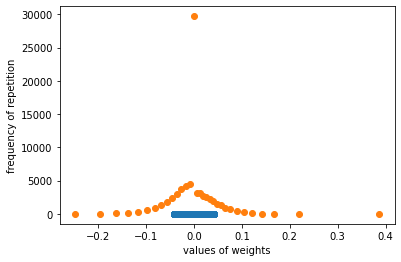

8
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


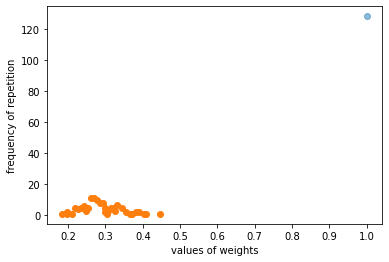

10
----------  name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 146813


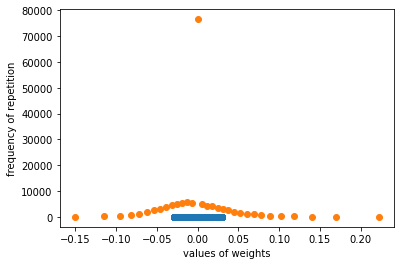

11
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


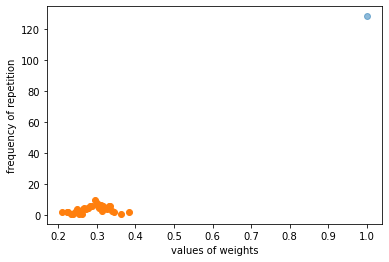

14
----------  name: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 292398


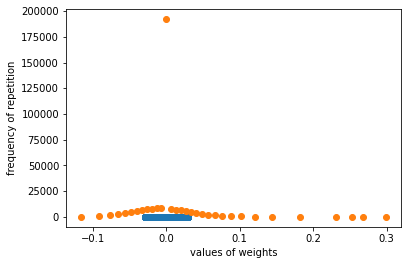

15
----------  name: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


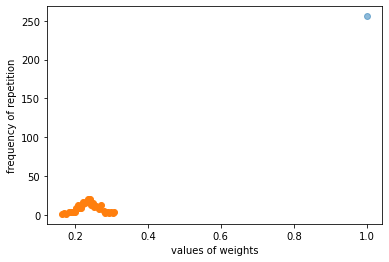

17
----------  name: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 579519


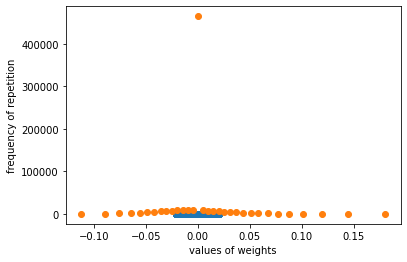

18
----------  name: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


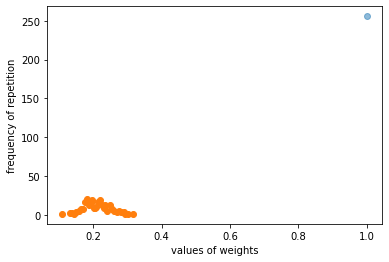

20
----------  name: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 579559


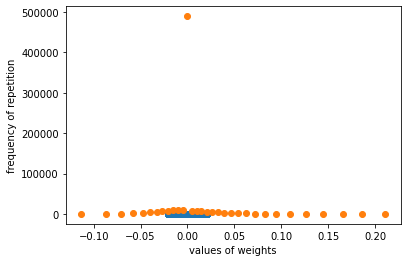

21
----------  name: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


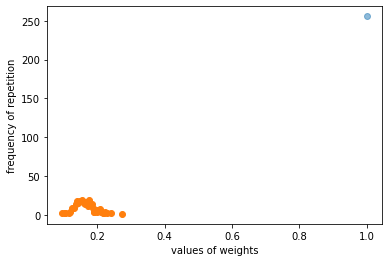

24
----------  name: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 1139169


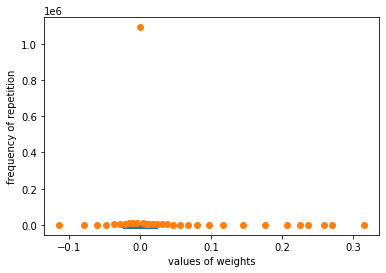

25
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


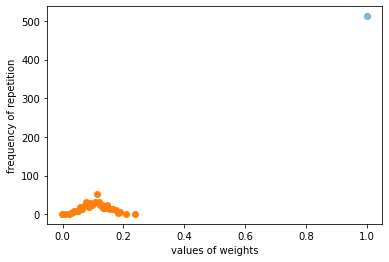

27
----------  name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 2200460


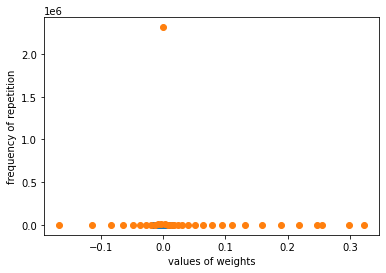

28
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


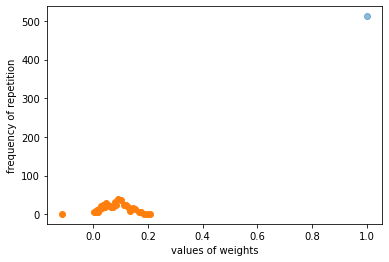

30
----------  name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 2200118


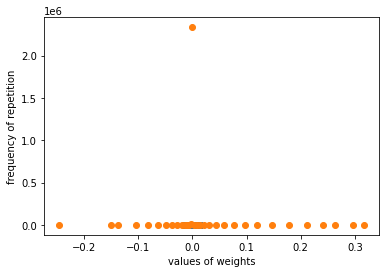

31
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


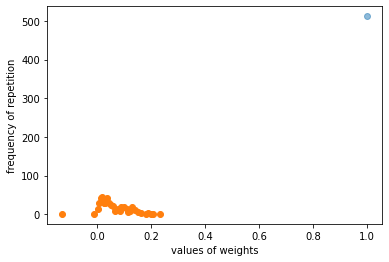

34
----------  name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 2200715


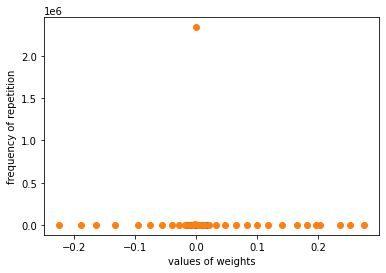

35
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


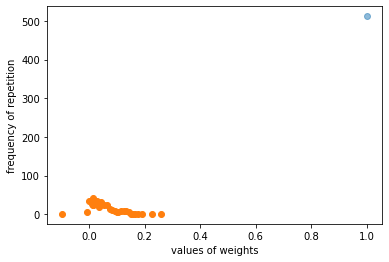

37
----------  name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 2200691


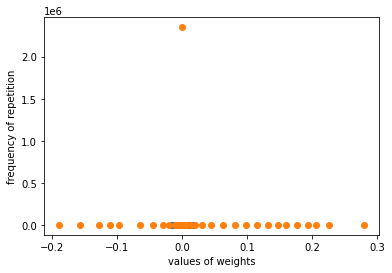

38
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


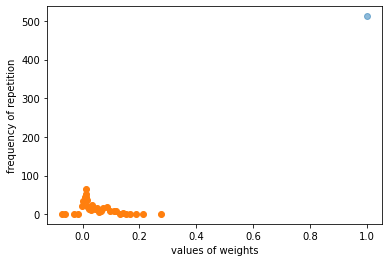

40
----------  name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
layer_names [ Conv2d ] -> unique weights count old: 32 , new: 2200907


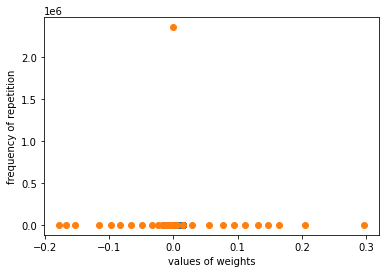

41
----------  name: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer_names [ BatchNorm2d ] -> unique weights count old: 32 , new: 1


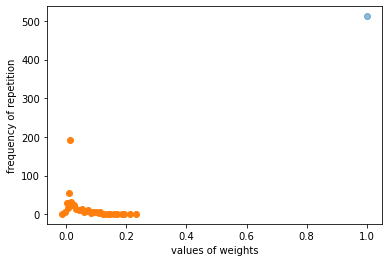

In [32]:
vn.display_scatter_plot(initial_net,post_process_net)

visualizing activations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


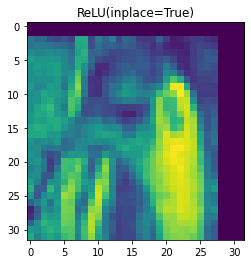

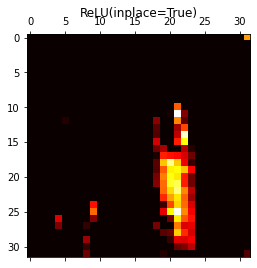

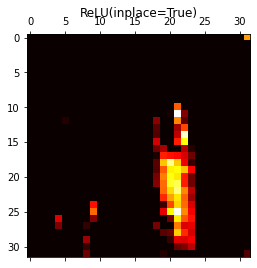

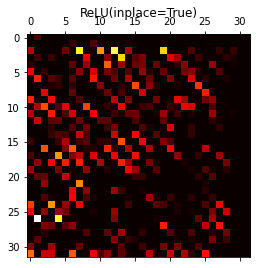

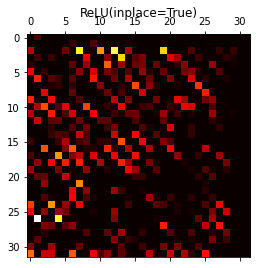

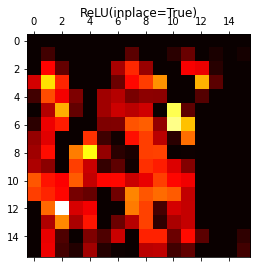

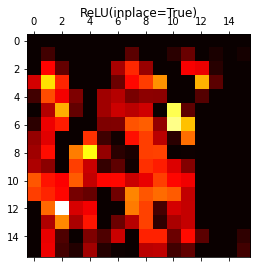

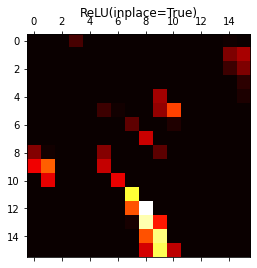

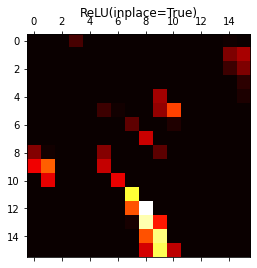

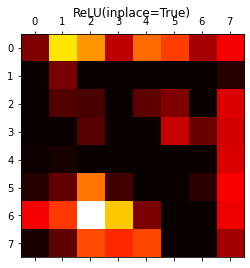

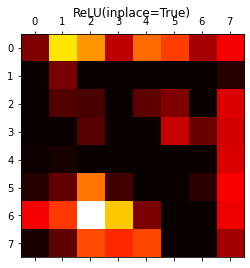

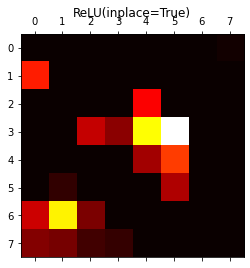

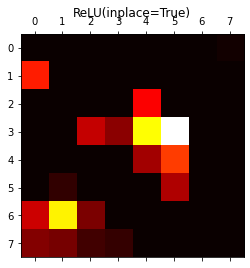

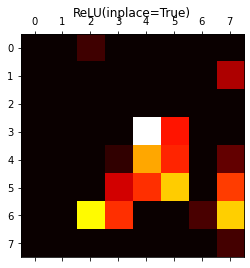

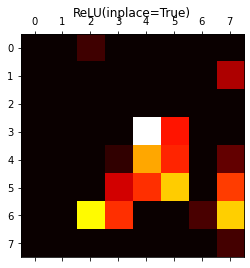

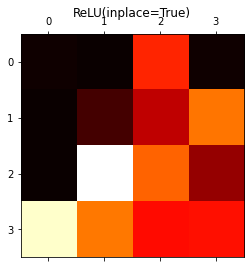

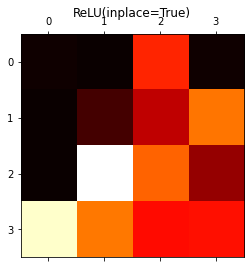

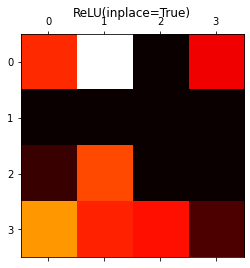

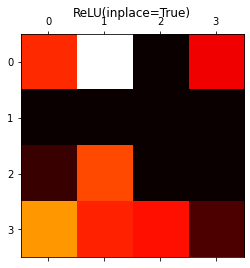

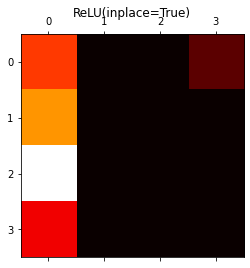

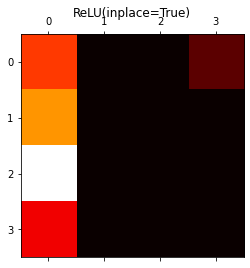

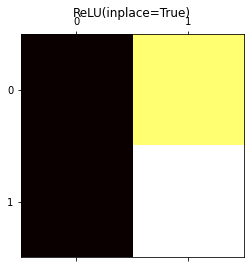

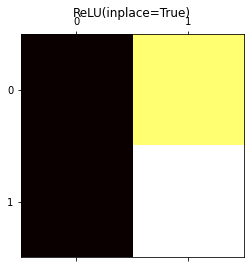

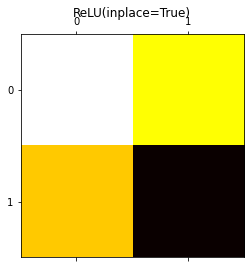

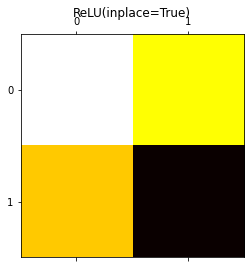

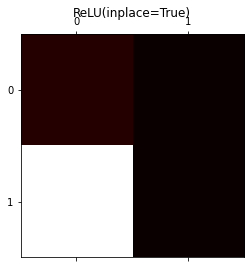

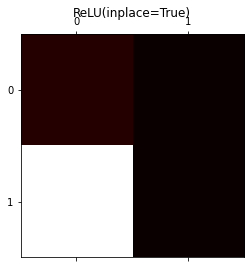

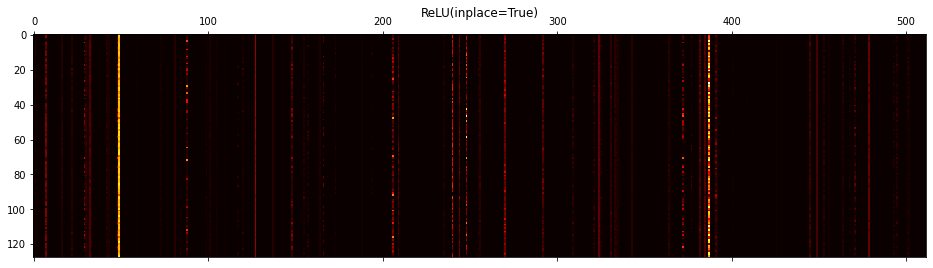

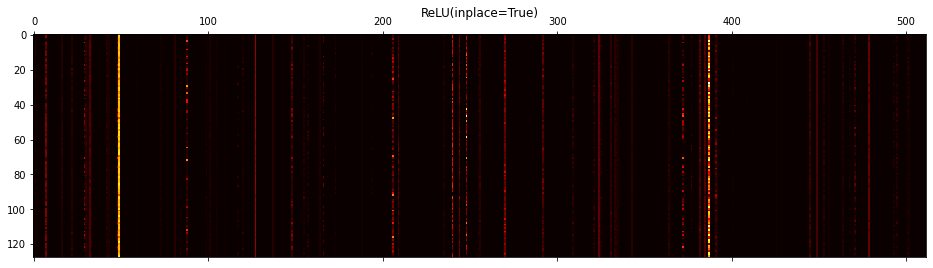

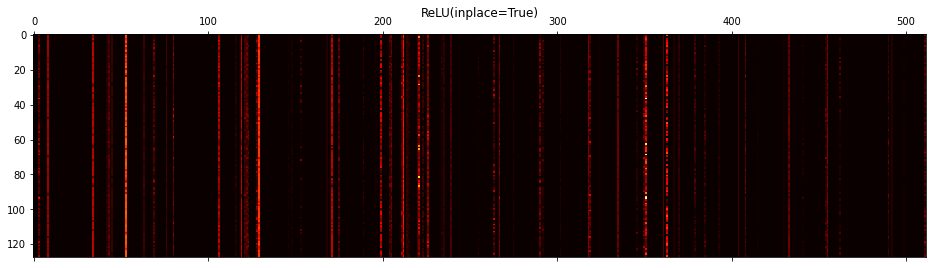

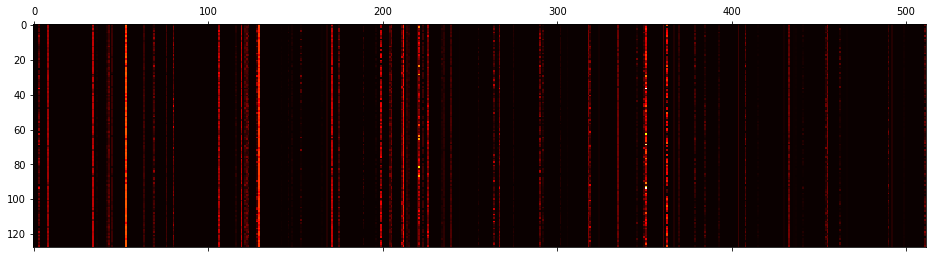

In [50]:
x = next(iter(train_loader))[0]
vn.display_activations(post_process_net,x)